## Fitting Linear Data   
In this assignment, we're interested in fitting the linear relationship between voltage, V, and current, I, via the relationship
$$ V = R I + V_o $$
where $R$ and $V_o$ are the values we're interested in fitting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.stats
import pandas as pd

In [2]:
# Let's define the model we're trying to fit
def voltage_linear(I, R, V_o):
    return R*I + V_o

In [3]:
# Linear fit parameters. Create dictionary of labels for pandas data table
parameters = ['V', 'I']

In [4]:
data = pd.read_csv('./data/lin2.dat', header=None, sep='\s+')
data.columns = parameters

In [5]:
# now, using the scipy.optimize module curve_fit, we can fit our data by minimizing chi-2.
best_params,param_covariance = curve_fit(f=voltage_linear, xdata= data['V'], ydata=data['I'])

# to compute the uncertainties of our parameter fits:
param_uncertainty = np.sqrt(np.diag(param_covariance))

print('R best fit value = ', best_params[0], '+/-', param_uncertainty[0])
print('V_o best fit value = ', best_params[1], '+/-', param_uncertainty[1])

R best fit value =  3.499858782235691 +/- 0.0005503460404014765
V_o best fit value =  2.02943382557733 +/- 0.03201486646760533


In [6]:
# now let's plot our data and overlay the best fit
# first unpack params
R_fit,V_o_fit = best_params

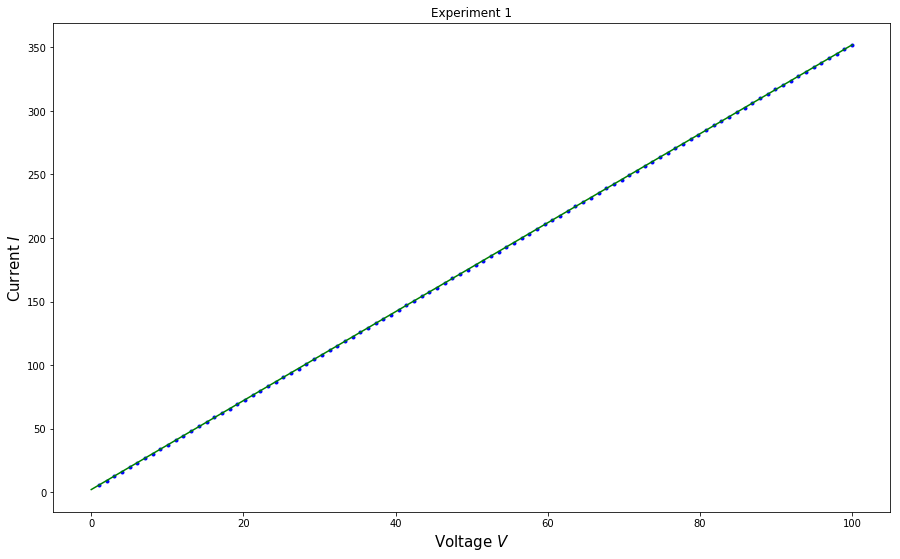

In [7]:
fig,ax = plt.subplots(1, 1, figsize=(15,9))

x = np.linspace(0, 100, 1000) # for plotting

ax.scatter(data['V'], data['I'], color = 'b', marker='.')
ax.plot(x, voltage_linear(I=x, R=R_fit, V_o=V_o_fit), color='g')
ax.set_xlabel('Voltage $V$', fontsize=15)
ax.set_ylabel('Current $I$', fontsize=15)
plt.title("Experiment 1")
plt.show()

In [12]:
# We just did one dataset. Next, let's fit all four of them at once and see how each of the fits perform
data_list = []
n_datfiles = 4
for i in range(n_datfiles):
    data_i = pd.read_csv('./data/lin{}.dat'.format(i+1), header=None, sep='\s+')
    data_i.columns = parameters
    data_list.append(data_i)

In [14]:
params = []      # list of best-fit parameters for each dataset
param_uncertainty = []  # list of fit uncertainties for each dataset
covariance = []
for i in range(n_datfiles):
    best_params,param_covariance = curve_fit(f=voltage_linear, xdata= data_list[i]['V'], ydata=data_list[i]['I'])
    params.append(best_params)
    covariance.append(param_covariance)
    # compute uncertainties
    p_err = np.sqrt(np.diag(param_covariance))
    param_uncertainty.append(p_err)

In [15]:
for i in range(len(params)):
    print('Experiment {} [R, V_o] ='.format(i+1), params[i])

Experiment 1 [R, V_o] = [3.50033154 1.97201253]
Experiment 2 [R, V_o] = [3.49985878 2.02943383]
Experiment 3 [R, V_o] = [3.50069977 1.98255649]
Experiment 4 [R, V_o] = [3.49834755 2.09210973]


In [16]:
#print('uncertainties', param_uncertainty)
print('Average Standard error on R = ', np.mean(param_uncertainty, axis=0)[0])
print('Average Standard error on V_o = ', np.mean(param_uncertainty, axis=0)[1])

Average Standard error on R =  0.0005296757332863777
Average Standard error on V_o =  0.03081241992283105


In [17]:
# plot colors
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']

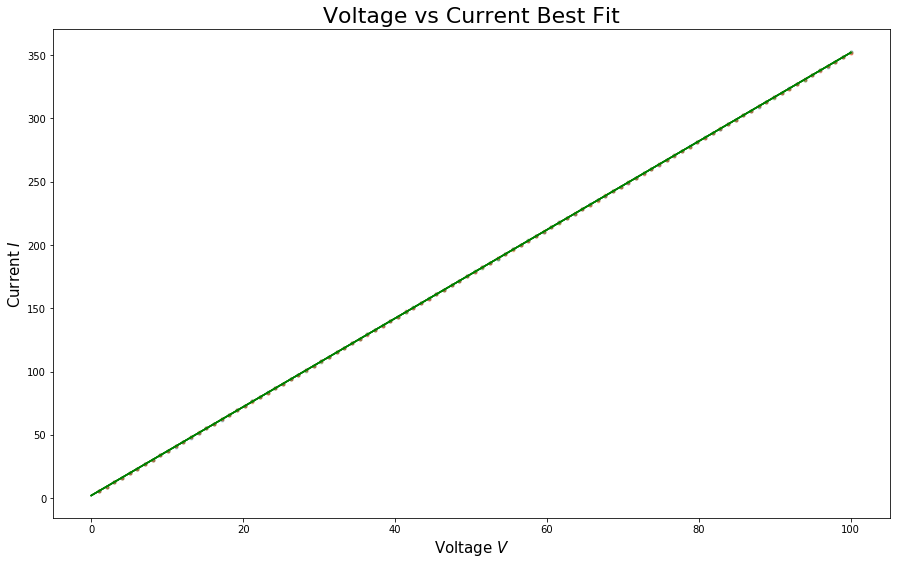

In [18]:
fig,ax = plt.subplots(1, 1, figsize=(15,9))
colors 
x = np.linspace(0, 100, 1000) # for plotting

for i in range(n_datfiles):
    ax.scatter(data_list[i]['V'], data_list[i]['I'], color = colors[i], marker='.', alpha=0.3)
    ax.plot(x, voltage_linear(I=x, R=params[i][0], V_o=params[i][1]), color='g')
plt.title('Voltage vs Current Best Fit', fontsize=22)
ax.set_xlabel('Voltage $V$', fontsize=15)
ax.set_ylabel('Current $I$', fontsize=15)
plt.show()

## Problem 2
Fitting Gaussian-distributed data. The dataset `gauss.dat` shows the number of counts observed in a given window of $s$ seconds. We're interested in fitting a bell curve to this distribution.

In [19]:
def H_fn(x, A, mean, sigma):
    return A*np.exp((-(x - mean)**2) / (2*(sigma**2)))

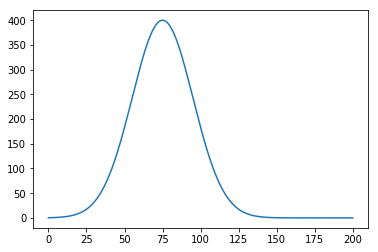

In [20]:
x = np.linspace(0, 200, 10000)
plt.plot(x, H_fn(x=x, A=400, mean=75, sigma=20))

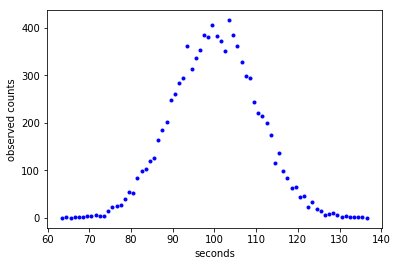

In [21]:
hist_data = pd.read_csv('data/gauss.dat', header=None, sep='\s+')
hist_data.columns = ['seconds', 'counts']
plt.scatter(hist_data['seconds'], hist_data['counts'], marker='.', color='b')
plt.xlabel('seconds')
plt.ylabel('observed counts')
plt.show()

Here we define our bins at each value for `s` that a number of counts were observed. As described in `fitting.py`, we need to bin the data and weight our fit to the *uncertainty* value of counts in each bin.

In [22]:
# histogram the data
nBins = 50
nCounts, binEdges = np.histogram(hist_data['counts'].values, bins=nBins)

In [23]:
# data is already in histogram form

In [24]:
nTrials = len(hist_data)

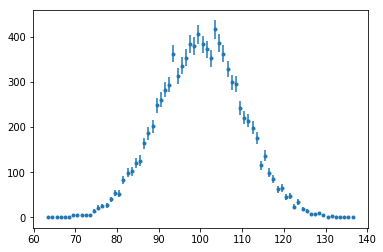

In [25]:
# There will be one more bin edge than the number of bins.
# For what follows, we are interested in the bin centers
binCenters = np.zeros(nBins)
for i in range(nBins) : binCenters[i] = 0.5*(binEdges[i+1]+binEdges[i])

# plot the generated points
ax = plt.subplot(111)
plotErrors = (hist_data['counts'].values)
plotErrors = np.sqrt(np.maximum(plotErrors,1))
plt.errorbar(hist_data['seconds'], hist_data['counts'],yerr=plotErrors,fmt='.')
plt.show()

Now we're looking to fit the data to our gaussian function `H_fn`, above.

In [29]:
# fit to a gaussian function
fitErrors = np.sqrt(hist_data['counts'].values + 1.)
initialGuess = [np.max(hist_data['counts'].values), 100, 15.]  # initial guess for each of the three parameters
fittedParameters, covariance = curve_fit(H_fn, hist_data['seconds'].values, hist_data['counts'].values, p0=initialGuess, sigma=fitErrors)
[ fittedAmplitude, fittedMean, fittedSigma ] = fittedParameters

# compute the analytic curve with fitted parameters
fittedCurve = H_fn(hist_data['seconds'].values, fittedAmplitude, fittedMean, fittedSigma)

In [30]:
# compute the errors in each of the parameters, using the covariance reduction formula from problem 1. 
param_uncertainty = np.sqrt(np.diag(covariance))
[errA, errMu, errSigma] = param_uncertainty

In [31]:
# now compute the chi-2 statistic
chisq = np.sum( ((hist_data['counts'].values-fittedCurve) / fitErrors)**2)
ndof = len(hist_data) - 3
pValue = 1. - scipy.stats.chi2.cdf(chisq,ndof)

Finally, a good metric to look at is the reduced $\chi$-2:
$$ \bar{\chi}^2 = \chi^2 - N_{dat} $$

In [34]:
reduced_chisq = chisq - len(hist_data)
print('reduced chi-2 value = ', reduced_chisq)

reduced chi-2 value =  -3.5854100604342705


Let's overlay the fitted curve over the scatter plot from above

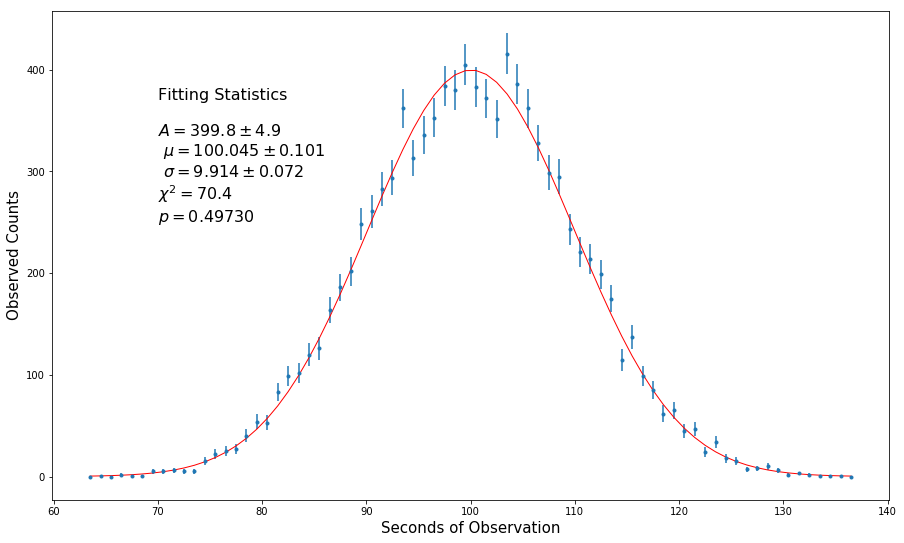

In [35]:
fig,ax = plt.subplots(1, 1, figsize=(15,9))
plotErrors = (hist_data['counts'].values)
plotErrors = np.sqrt(np.maximum(plotErrors,1))
ax.errorbar(hist_data['seconds'], hist_data['counts'],yerr=plotErrors,fmt='.') 
ax.plot(hist_data['seconds'], fittedCurve, 'r-', linewidth=1)

ax.set_xlabel('Seconds of Observation', fontsize=15)
ax.set_ylabel("Observed Counts", fontsize=15)

textString = "Fitting Statistics \n\n$A={0:6.1f} \pm {1:4.1f}$ \n $\mu={2:8.3f} \pm {3:6.3f}$ \n $\sigma={4:8.3f} \pm {5:6.3f}$ ".format(
    fittedAmplitude, errA, fittedMean, errMu, fittedSigma, errSigma)
textString += "\n$\chi^2={0:5.1f}$  \n$p={1:8.5f}$".format(chisq, pValue) 

plt.text(70, 380, textString, fontsize=16, verticalalignment='top')

plt.show()